# Multivariate LSTM for Weather Temperature Prediction

This notebook demonstrates temperature prediction using a **multivariate LSTM** model that leverages multiple weather features:
- Mean Temperature (target variable)
- Maximum Temperature
- Minimum Temperature
- Precipitation
- Snowfall

**Key Differences from Univariate Model:**
- Uses multiple input features instead of just temperature
- Learns relationships between different weather variables
- Potentially higher accuracy through richer context

**Data Source:** Summary of Weather.csv

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Keras and TensorFlow imports
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")

2026-02-01 21:10:34.904516: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-01 21:10:34.941655: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-01 21:10:45.103370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ All libraries imported successfully!


## 2. Load and Explore Data

In [2]:
# Load data
df = pd.read_csv('Summary of Weather.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

print(f"✅ Data loaded successfully!")
print(f"📊 Shape: {df.shape}")
print(f"\n📋 Columns: {df.columns.tolist()}")

# Check for station information
if 'STA' in df.columns:
    unique_stations = df['STA'].unique()
    print(f"\n🏢 Number of unique stations: {len(unique_stations)}")
    print(f"📍 Station IDs: {unique_stations}")
    
    # Select station with most records
    station_counts = df['STA'].value_counts()
    selected_station = station_counts.index[0]
    df = df[df['STA'] == selected_station].copy()
    print(f"\n🎯 Selected Station {selected_station} (largest dataset: {station_counts.iloc[0]} records)")
else:
    selected_station = None
    print("\n⚠️  No station column found, using all data")

print(f"\n📊 Final data shape: {df.shape}")
df.head()

✅ Data loaded successfully!
📊 Shape: (119040, 31)

📋 Columns: ['STA', 'Date', 'Precip', 'WindGustSpd', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA', 'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF', 'SD3', 'RHX', 'RHN', 'RVG', 'WTE']

🏢 Number of unique stations: 159
📍 Station IDs: [22504 22508 10701 22509 22502 10803 11610 16405 11601 10502 16202 10705
 11604 20501 16504 13601 11704 10804 10806 11901 50801 81702 16407 32601
 22507 11701 82403 32801 10001 82402 10102 12701 81404 82404 32701 11606
 60701 10718 31701 50401 11801 11902 32803 33031 13002 32805 50802 62701
 81601 33044 13005 13007 82502 33013 12001 11101 12101 33023 12801 31401
 31501 21501 50302 32904 16201 50403 82405 32501 32907 31001 31101 82501
 30001 10002 10802 10101 10703 10704 50304 61502 61501 50303 32702 33117
 82503 33109 33121 50301 11501 34105 80411 10505 33111 33303 33014 32906
 33501 33019 33401 34104 34109 34002 80412 8050

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
57877,22508,1940-01-01,0.254,NaN,23.333333,17.222222,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57878,22508,1940-01-02,10.16,NaN,23.333333,16.111111,19.444444,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57879,22508,1940-01-03,T,NaN,23.888889,15.555556,20.000000,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57880,22508,1940-01-04,2.286,NaN,23.888889,18.333333,21.111111,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57881,22508,1940-01-05,0.254,NaN,22.222222,15.000000,18.333333,0,NaN,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Display data info
print("📊 Data Info:")
print("="*70)
df.info()

print("\n📈 Statistical Summary:")
print("="*70)
df.describe()

📊 Data Info:
<class 'pandas.DataFrame'>
Index: 2192 entries, 57877 to 60068
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   STA          2192 non-null   int64         
 1   Date         2192 non-null   datetime64[us]
 2   Precip       2192 non-null   str           
 3   WindGustSpd  0 non-null      float64       
 4   MaxTemp      2192 non-null   float64       
 5   MinTemp      2192 non-null   float64       
 6   MeanTemp     2192 non-null   float64       
 7   Snowfall     2192 non-null   object        
 8   PoorWeather  470 non-null    object        
 9   YR           2192 non-null   int64         
 10  MO           2192 non-null   int64         
 11  DA           2192 non-null   int64         
 12  PRCP         2192 non-null   str           
 13  DR           0 non-null      float64       
 14  SPD          0 non-null      float64       
 15  MAX          2192 non-null   float64       
 16  MIN 

,STA,Date,WindGustSpd,MaxTemp,MinTemp,MeanTemp,YR,MO,DA,DR,...,FT,FB,FTI,ITH,PGT,SD3,RHX,RHN,RVG,WTE
count,2192.0,2192,0.0,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,22508.0,1942-12-31 12:00:00,NaN,26.175233,18.411395,22.296229,42.499544,6.521898,15.732664,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,22508.0,1940-01-01 00:00:00,NaN,17.777778,11.666667,15.555556,40.000000,1.000000,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,22508.0,1941-07-01 18:00:00,NaN,25.000000,17.222222,21.111111,41.000000,4.000000,8.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,22508.0,1942-12-31 12:00:00,NaN,26.666667,18.888889,22.222222,42.500000,7.000000,16.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,22508.0,1944-07-01 06:00:00,NaN,27.777778,20.000000,23.333333,44.000000,10.000000,23.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,22508.0,1945-12-31 00:00:00,NaN,31.666667,22.777778,26.111111,45.000000,12.000000,31.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.0,NaN,NaN,2.094557,2.072139,1.799486,1.708571,3.449773,8.803378,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Feature Selection and Preprocessing

In [4]:
# Define features to use for multivariate prediction
# We'll predict MeanTemp using multiple weather variables

# Handle 'T' in precipitation-like columns if they exist
for col in ["Precip", "PRCP"]:
    if col in df.columns:
        if df[col].dtype in ("str", "object"):
            df[col] = df[col].replace("T", 0.0)
        # Cast to float
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Convert any remaining object columns that look numeric
for col in df.columns:
    if df[col].dtype == "object":
        # Try to coerce to numeric, keep non-numeric as NaN
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Identify available features in the dataset
potential_features = ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall']
available_features = [col for col in potential_features if col in df.columns]

print("🔍 Feature Selection:")
print("="*70)
print(f"Potential features: {potential_features}")
print(f"Available features: {available_features}")

if len(available_features) < 2:
    print("\n⚠️  Warning: Less than 2 features available. Multivariate model requires multiple features.")
    print("Available columns:", df.columns.tolist())
else:
    print(f"\n✅ Using {len(available_features)} features for multivariate LSTM")

# Handle missing values
print("\n🔍 Missing Values:")
print("="*70)
missing_counts = df[available_features].isnull().sum()
for feature, count in missing_counts.items():
    if count > 0:
        print(f"  {feature}: {count} ({count/len(df)*100:.2f}%)")

# Fill missing values
df[available_features] = df[available_features].ffill().bfill()
df = df.dropna(subset=available_features)

print(f"\n✅ Missing values handled. Final shape: {df.shape}")

🔍 Feature Selection:
Potential features: ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall']
Available features: ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall']

✅ Using 5 features for multivariate LSTM

🔍 Missing Values:

✅ Missing values handled. Final shape: (2192, 31)


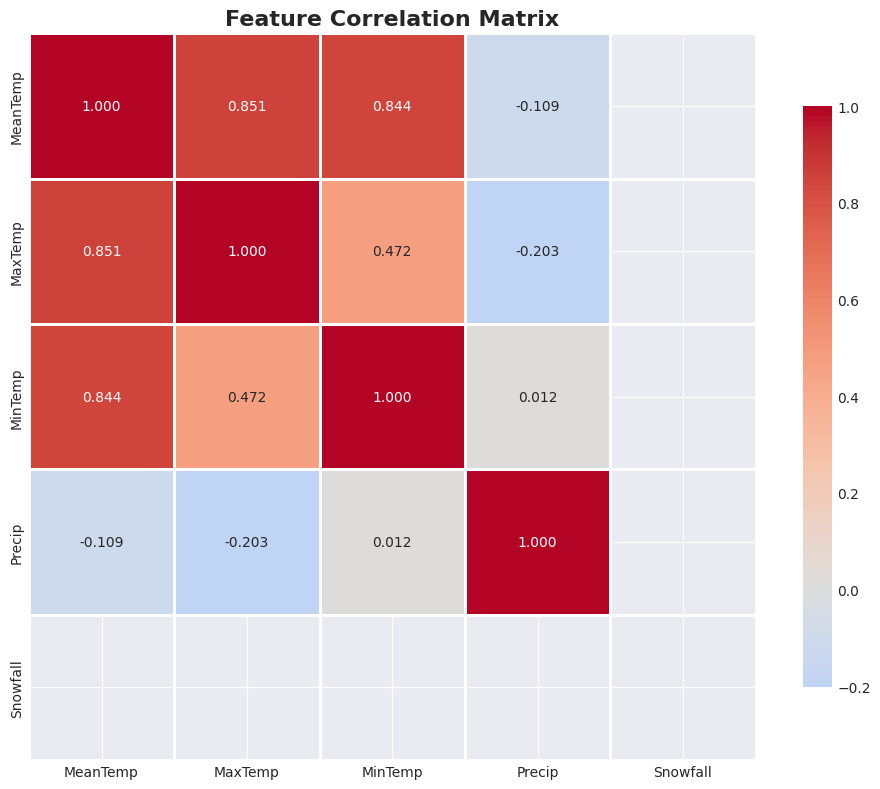


📊 Correlation Insights:
Correlations with MeanTemp (target):
  MaxTemp        : +0.851
  MinTemp        : +0.844
  Precip         : -0.109
  Snowfall       : +nan


In [5]:
# Visualize feature correlations
plt.figure(figsize=(10, 8))
correlation_matrix = df[available_features].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Correlation Insights:")
print("="*70)
# Find strongest correlations with MeanTemp
if 'MeanTemp' in available_features:
    correlations = correlation_matrix['MeanTemp'].sort_values(ascending=False)
    print("Correlations with MeanTemp (target):")
    for feature, corr in correlations.items():
        if feature != 'MeanTemp':
            print(f"  {feature:15s}: {corr:+.3f}")

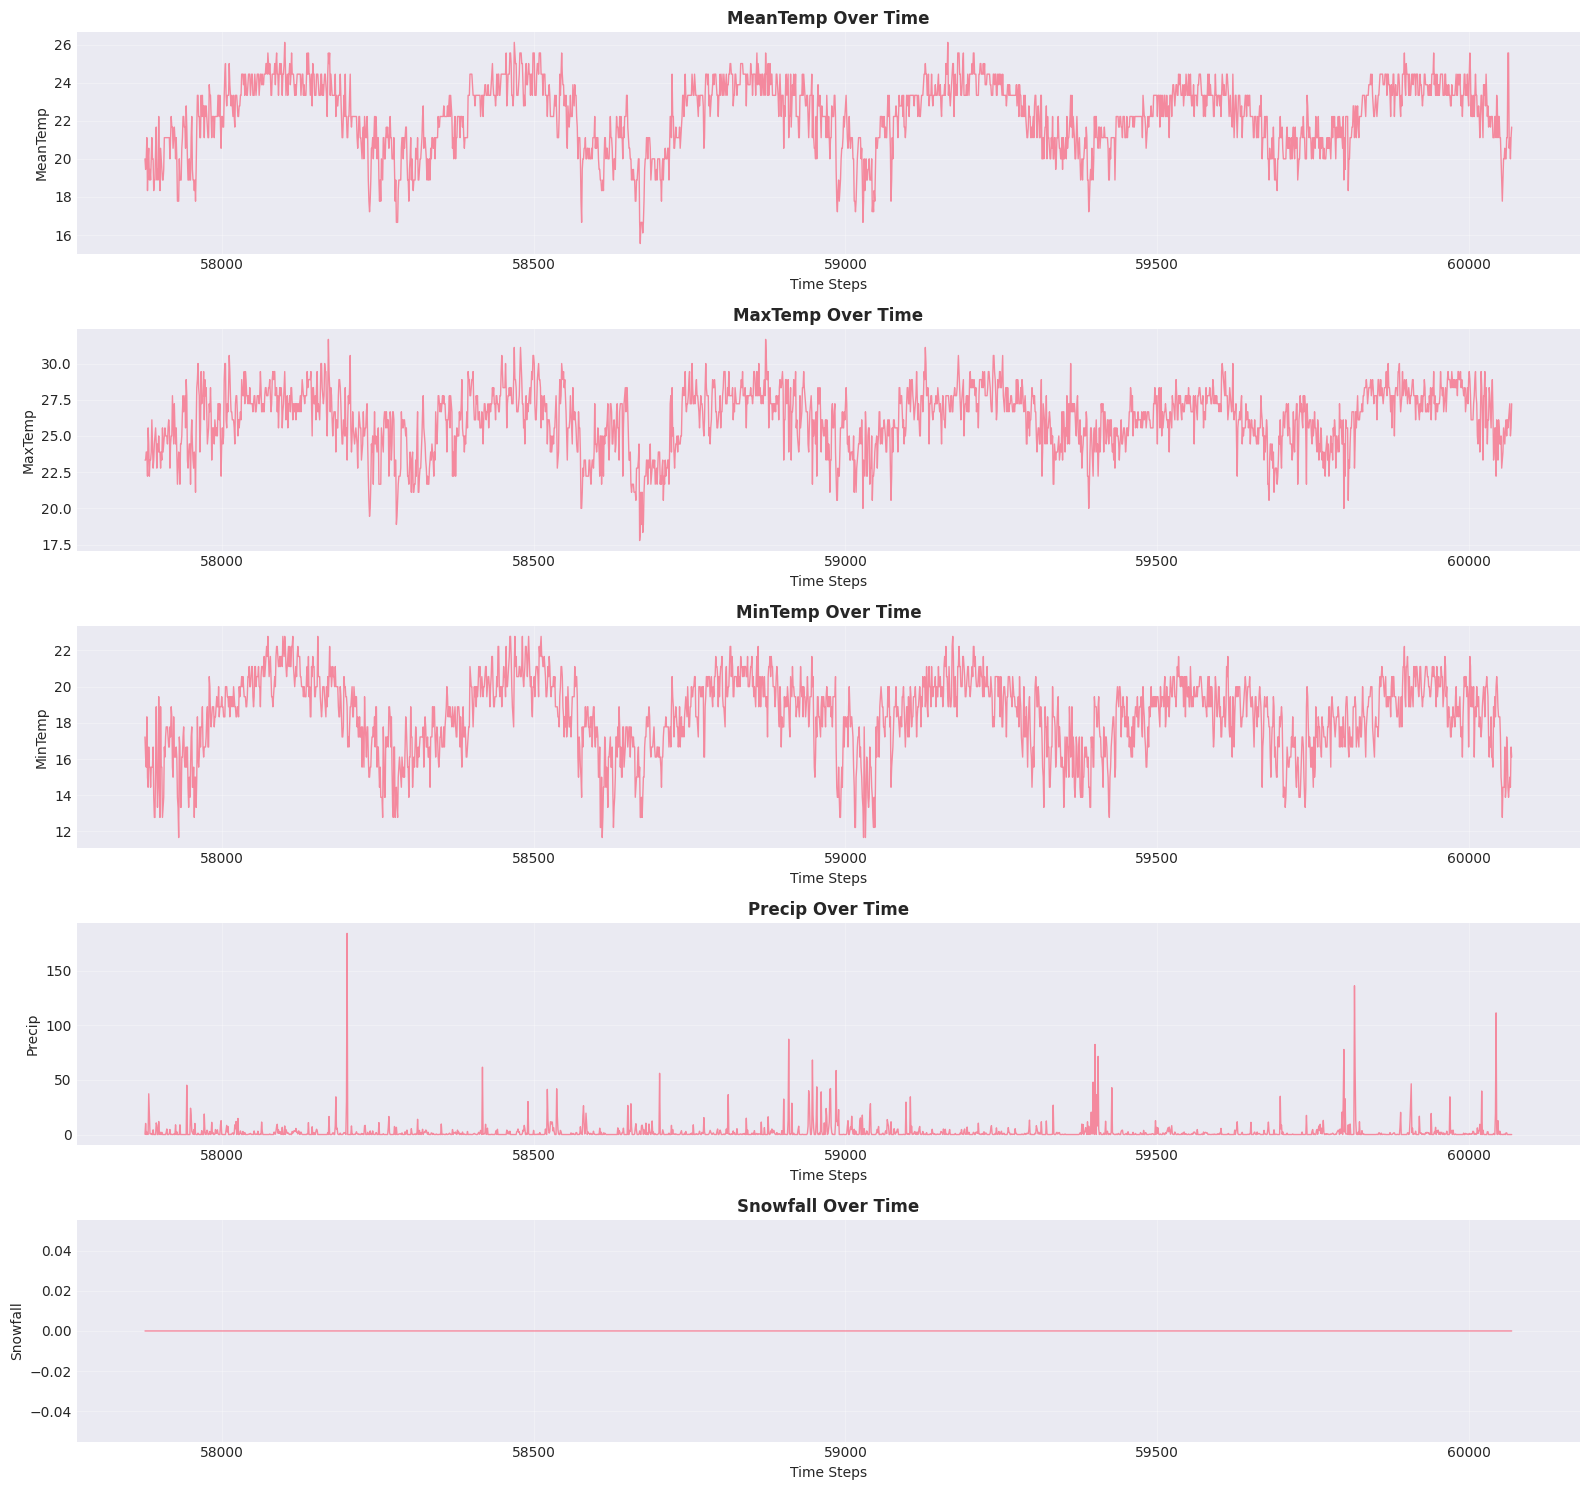

In [6]:
# Visualize all features over time
fig, axes = plt.subplots(len(available_features), 1, figsize=(16, 3*len(available_features)))
if len(available_features) == 1:
    axes = [axes]

for idx, feature in enumerate(available_features):
    axes[idx].plot(df.index, df[feature], linewidth=1, alpha=0.8)
    axes[idx].set_title(f'{feature} Over Time', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Steps', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Prepare Multivariate Data for LSTM

In [7]:
def create_multivariate_sequences(data: np.ndarray, lookback: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sequences for multivariate LSTM training.
    
    Args:
        data: Input data array (scaled) with shape (samples, features)
        lookback: Number of time steps to look back
        
    Returns:
        Tuple of (X, y) arrays where:
        - X shape: (samples, lookback, num_features)
        - y shape: (samples,) - predicting only MeanTemp (first feature)
    """
    X = []
    y = []
    
    for i in range(lookback, len(data)):
        # X contains all features for the lookback period
        X.append(data[i-lookback:i, :])
        # y contains only the target (MeanTemp - first column) for next time step
        y.append(data[i, 0])
    
    X_array = np.array(X)
    y_array = np.array(y)
    
    return X_array, y_array

# Extract feature data
feature_data = df[available_features].values
print(f"📊 Feature data shape: {feature_data.shape} (samples, features)")
print(f"📊 Features used: {available_features}")

# Normalize each feature independently
scaler = MinMaxScaler(feature_range=(0, 1))
feature_data_scaled = scaler.fit_transform(feature_data)

print(f"\n✅ Data normalized to range [0, 1]")
print(f"📊 Scaled data shape: {feature_data_scaled.shape}")

# Split into train and test sets (80-20 split)
train_size = int(len(feature_data_scaled) * 0.8)
train_data = feature_data_scaled[:train_size]
test_data = feature_data_scaled[train_size:]

print(f"\n📊 Training data size: {train_size} ({train_size/len(feature_data_scaled)*100:.1f}%)")
print(f"📊 Testing data size: {len(test_data)} ({len(test_data)/len(feature_data_scaled)*100:.1f}%)")

# Create sequences
lookback = 60  # Use past 60 time steps to predict next value
print(f"\n🔄 Creating multivariate sequences with lookback period: {lookback} days")

X_train, y_train = create_multivariate_sequences(train_data, lookback)
X_test, y_test = create_multivariate_sequences(test_data, lookback)

print(f"\n✅ Multivariate sequences created successfully!")
print(f"📊 X_train shape: {X_train.shape} (samples, time_steps, features)")
print(f"📊 y_train shape: {y_train.shape} (samples,)")
print(f"📊 X_test shape: {X_test.shape}")
print(f"📊 y_test shape: {y_test.shape}")
print(f"\n🎯 Target variable: {available_features[0]} (first feature)")
print(f"📊 Input features: {len(available_features)} features")

📊 Feature data shape: (2192, 5) (samples, features)
📊 Features used: ['MeanTemp', 'MaxTemp', 'MinTemp', 'Precip', 'Snowfall']

✅ Data normalized to range [0, 1]
📊 Scaled data shape: (2192, 5)

📊 Training data size: 1753 (80.0%)
📊 Testing data size: 439 (20.0%)

🔄 Creating multivariate sequences with lookback period: 60 days

✅ Multivariate sequences created successfully!
📊 X_train shape: (1693, 60, 5) (samples, time_steps, features)
📊 y_train shape: (1693,) (samples,)
📊 X_test shape: (379, 60, 5)
📊 y_test shape: (379,)

🎯 Target variable: MeanTemp (first feature)
📊 Input features: 5 features


## 5. Build Multivariate LSTM Model

In [8]:
def build_multivariate_lstm(input_shape: Tuple[int, int], 
                           lstm_units: List[int] = [50, 50],
                           dropout_rate: float = 0.2) -> Sequential:
    """
    Build multivariate LSTM model for temperature prediction.
    
    Args:
        input_shape: Shape of input data (time steps, num_features)
        lstm_units: List of units for each LSTM layer
        dropout_rate: Dropout rate for regularization
        
    Returns:
        Compiled Keras Sequential model
    """
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=lstm_units[0], return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer
    model.add(LSTM(units=lstm_units[1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Output layer (predicting single value: MeanTemp)
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

# Build the model
print(f"🏗️  Building Multivariate LSTM model...")
model = build_multivariate_lstm(
    input_shape=(X_train.shape[1], X_train.shape[2]),  # (time_steps, num_features)
    lstm_units=[50, 50],
    dropout_rate=0.2
)

print("\n📋 Model Architecture:")
print("="*70)
model.summary()
print("="*70)
print("✅ Multivariate LSTM model built successfully!")
print(f"\n🔑 Key Difference from Univariate Model:")
print(f"   Input shape: ({X_train.shape[1]}, {X_train.shape[2]}) instead of ({X_train.shape[1]}, 1)")
print(f"   The model now processes {X_train.shape[2]} features simultaneously")

🏗️  Building Multivariate LSTM model...


I0000 00:00:1769973051.890822  135033 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13730 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:02:00.0, compute capability: 8.9



📋 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

✅ Multivariate LSTM model built successfully!

🔑 Key Difference from Univariate Model:
   Input shape: (60, 5) instead of (60, 1)
   The model now processes 5 features simultaneously


## 6. Train the Multivariate Model

In [9]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

station_suffix = f"_station_{selected_station}" if selected_station else ""
model_checkpoint = ModelCheckpoint(
    f'best_multivariate_lstm{station_suffix}.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
print(f"🚀 Training the multivariate LSTM model...")
print("="*70)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("\n" + "="*70)
print("✅ Training completed!")
print(f"📊 Total epochs trained: {len(history.history['loss'])}")
print(f"📊 Final training loss: {history.history['loss'][-1]:.6f}")
print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.6f}")

🚀 Training the multivariate LSTM model...
Epoch 1/100


2026-02-01 21:10:54.230950: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801


41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1143 - mae: 0.2593
Epoch 1: val_loss improved from None to 0.00773, saving model to best_multivariate_lstm_station_22508.h5



Epoch 1: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0498 - mae: 0.1646 - val_loss: 0.0077 - val_mae: 0.0704
Epoch 2/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0196 - mae: 0.1101
Epoch 2: val_loss improved from 0.00773 to 0.00733, saving model to best_multivariate_lstm_station_22508.h5



Epoch 2: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0181 - mae: 0.1051 - val_loss: 0.0073 - val_mae: 0.0643
Epoch 3/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0168 - mae: 0.1024
Epoch 3: val_loss improved from 0.00733 to 0.00729, saving model to best_multivariate_lstm_station_22508.h5



Epoch 3: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0163 - mae: 0.1001 - val_loss: 0.0073 - val_mae: 0.0682
Epoch 4/100
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0156 - mae: 0.0986
Epoch 4: val_loss improved from 0.00729 to 0.00693, saving model to best_multivariate_lstm_station_22508.h5



Epoch 4: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0153 - mae: 0.0969 - val_loss: 0.0069 - val_mae: 0.0652
Epoch 5/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0158 - mae: 0.0984
Epoch 5: val_loss improved from 0.00693 to 0.00675, saving model to best_multivariate_lstm_station_22508.h5



Epoch 5: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0151 - mae: 0.0964 - val_loss: 0.0068 - val_mae: 0.0636
Epoch 6/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0144 - mae: 0.0934
Epoch 6: val_loss did not improve from 0.00675
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0144 - mae: 0.0938 - val_loss: 0.0083 - val_mae: 0.0746
Epoch 7/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0156 - mae: 0.0983
Epoch 7: val_loss did not improve from 0.00675
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0155 - mae: 0.0987 - val_loss: 0.0068 - val_mae: 0.0649
Epoch 8/100
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0145 - mae: 0.0957
Epoch 8: val_loss did not improve from 0.00675
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0142 - mae: 0.0941 - val_loss: 0.0068 - val_mae: 0.0651
Epoch 9/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0135 - mae: 0.0918
Epoch 9: val_loss did not improve fr


Epoch 10: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0137 - mae: 0.0917 - val_loss: 0.0067 - val_mae: 0.0639
Epoch 11/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0128 - mae: 0.0890
Epoch 11: val_loss did not improve from 0.00668
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0127 - mae: 0.0892 - val_loss: 0.0070 - val_mae: 0.0664
Epoch 12/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0136 - mae: 0.0910
Epoch 12: val_loss did not improve from 0.00668
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0134 - mae: 0.0903 - val_loss: 0.0070 - val_mae: 0.0662
Epoch 13/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0128 - mae: 0.0871
Epoch 13: val_loss improved from 0.00668 to 0.00631, saving model to best_multivariate_lstm_station_22508.h5



Epoch 13: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0127 - mae: 0.0874 - val_loss: 0.0063 - val_mae: 0.0607
Epoch 14/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0123 - mae: 0.0860
Epoch 14: val_loss did not improve from 0.00631
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0124 - mae: 0.0869 - val_loss: 0.0067 - val_mae: 0.0646
Epoch 15/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0127 - mae: 0.0889
Epoch 15: val_loss did not improve from 0.00631
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0127 - mae: 0.0885 - val_loss: 0.0073 - val_mae: 0.0691
Epoch 16/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0135 - mae: 0.0910
Epoch 16: val_loss did not improve from 0.00631
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0130 - mae: 0.0894 - val_loss: 0.0066 - val_mae: 0.0639
Epoch 17/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127 - mae: 0.0875
Epoch 17: val_loss did not i


Epoch 21: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0107 - mae: 0.0810 - val_loss: 0.0062 - val_mae: 0.0611
Epoch 22/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - mae: 0.0829
Epoch 22: val_loss improved from 0.00615 to 0.00598, saving model to best_multivariate_lstm_station_22508.h5



Epoch 22: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0111 - mae: 0.0822 - val_loss: 0.0060 - val_mae: 0.0597
Epoch 23/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0108 - mae: 0.0815
Epoch 23: val_loss did not improve from 0.00598
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0105 - mae: 0.0802 - val_loss: 0.0062 - val_mae: 0.0619
Epoch 24/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - mae: 0.0782
Epoch 24: val_loss did not improve from 0.00598
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0101 - mae: 0.0791 - val_loss: 0.0061 - val_mae: 0.0607
Epoch 25/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0107 - mae: 0.0809
Epoch 25: val_loss did not improve from 0.00598
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0106 - mae: 0.0804 - val_loss: 0.0066 - val_mae: 0.0644
Epoch 26/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0103 - mae: 0.0783
Epoch 26: val_loss did not i


Epoch 32: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0097 - mae: 0.0772 - val_loss: 0.0059 - val_mae: 0.0597
Epoch 33/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0095 - mae: 0.0757
Epoch 33: val_loss improved from 0.00595 to 0.00594, saving model to best_multivariate_lstm_station_22508.h5



Epoch 33: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0096 - mae: 0.0769 - val_loss: 0.0059 - val_mae: 0.0597
Epoch 34/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0095 - mae: 0.0759
Epoch 34: val_loss improved from 0.00594 to 0.00592, saving model to best_multivariate_lstm_station_22508.h5



Epoch 34: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0097 - mae: 0.0770 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 35/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093 - mae: 0.0751
Epoch 35: val_loss did not improve from 0.00592
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0097 - mae: 0.0771 - val_loss: 0.0069 - val_mae: 0.0664
Epoch 36/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0101 - mae: 0.0799
Epoch 36: val_loss did not improve from 0.00592
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0097 - mae: 0.0777 - val_loss: 0.0064 - val_mae: 0.0635
Epoch 37/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0099 - mae: 0.0781
Epoch 37: val_loss improved from 0.00592 to 0.00587, saving model to best_multivariate_lstm_station_22508.h5



Epoch 37: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - mae: 0.0757 - val_loss: 0.0059 - val_mae: 0.0589
Epoch 38/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0096 - mae: 0.0764
Epoch 38: val_loss did not improve from 0.00587
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0091 - mae: 0.0757 - val_loss: 0.0061 - val_mae: 0.0611
Epoch 39/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0097 - mae: 0.0779
Epoch 39: val_loss did not improve from 0.00587
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0095 - mae: 0.0767 - val_loss: 0.0060 - val_mae: 0.0600
Epoch 40/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092 - mae: 0.0756
Epoch 40: val_loss improved from 0.00587 to 0.00584, saving model to best_multivariate_lstm_station_22508.h5



Epoch 40: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0089 - mae: 0.0744 - val_loss: 0.0058 - val_mae: 0.0585
Epoch 41/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0092 - mae: 0.0747
Epoch 41: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0094 - mae: 0.0755 - val_loss: 0.0061 - val_mae: 0.0610
Epoch 42/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0094 - mae: 0.0763
Epoch 42: val_loss improved from 0.00584 to 0.00584, saving model to best_multivariate_lstm_station_22508.h5



Epoch 42: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0090 - mae: 0.0746 - val_loss: 0.0058 - val_mae: 0.0586
Epoch 43/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - mae: 0.0754
Epoch 43: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0089 - mae: 0.0751 - val_loss: 0.0059 - val_mae: 0.0592
Epoch 44/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090 - mae: 0.0744
Epoch 44: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0090 - mae: 0.0741 - val_loss: 0.0061 - val_mae: 0.0610
Epoch 45/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0091 - mae: 0.0745
Epoch 45: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0091 - mae: 0.0750 - val_loss: 0.0060 - val_mae: 0.0605
Epoch 46/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0089 - mae: 0.0728
Epoch 46: val_loss did not i


Epoch 51: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0089 - mae: 0.0750 - val_loss: 0.0058 - val_mae: 0.0589
Epoch 52/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - mae: 0.0715
Epoch 52: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0084 - mae: 0.0713 - val_loss: 0.0059 - val_mae: 0.0594
Epoch 53/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0088 - mae: 0.0738
Epoch 53: val_loss did not improve from 0.00584
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0086 - mae: 0.0725 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 54/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0091 - mae: 0.0744
Epoch 54: val_loss improved from 0.00584 to 0.00583, saving model to best_multivariate_lstm_station_22508.h5



Epoch 54: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0086 - mae: 0.0722 - val_loss: 0.0058 - val_mae: 0.0587
Epoch 55/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083 - mae: 0.0717
Epoch 55: val_loss did not improve from 0.00583
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - mae: 0.0717 - val_loss: 0.0062 - val_mae: 0.0612
Epoch 56/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - mae: 0.0730
Epoch 56: val_loss did not improve from 0.00583
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - mae: 0.0714 - val_loss: 0.0059 - val_mae: 0.0590
Epoch 57/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - mae: 0.0725
Epoch 57: val_loss did not improve from 0.00583
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - mae: 0.0717 - val_loss: 0.0059 - val_mae: 0.0592
Epoch 58/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - mae: 0.0714
Epoch 58: val_loss did not i


Epoch 59: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0082 - mae: 0.0709 - val_loss: 0.0058 - val_mae: 0.0587
Epoch 60/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083 - mae: 0.0706
Epoch 60: val_loss did not improve from 0.00581
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - mae: 0.0718 - val_loss: 0.0059 - val_mae: 0.0598
Epoch 61/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0086 - mae: 0.0721
Epoch 61: val_loss did not improve from 0.00581
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0083 - mae: 0.0710 - val_loss: 0.0058 - val_mae: 0.0588
Epoch 62/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - mae: 0.0693
Epoch 62: val_loss did not improve from 0.00581
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - mae: 0.0686 - val_loss: 0.0059 - val_mae: 0.0593
Epoch 63/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0083 - mae: 0.0714
Epoch 63: val_loss did not i


Epoch 64: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0083 - mae: 0.0714 - val_loss: 0.0058 - val_mae: 0.0588
Epoch 65/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0085 - mae: 0.0725
Epoch 65: val_loss did not improve from 0.00580
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - mae: 0.0706 - val_loss: 0.0059 - val_mae: 0.0591
Epoch 66/100
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - mae: 0.0716
Epoch 66: val_loss did not improve from 0.00580
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - mae: 0.0715 - val_loss: 0.0058 - val_mae: 0.0589
Epoch 67/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - mae: 0.0715
Epoch 67: val_loss did not improve from 0.00580
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0080 - mae: 0.0709 - val_loss: 0.0058 - val_mae: 0.0589
Epoch 68/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - mae: 0.0697
Epoch 68: val_loss did not i


Epoch 70: finished saving model to best_multivariate_lstm_station_22508.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0079 - mae: 0.0695 - val_loss: 0.0058 - val_mae: 0.0585
Epoch 71/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0083 - mae: 0.0710
Epoch 71: val_loss did not improve from 0.00578
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0081 - mae: 0.0703 - val_loss: 0.0059 - val_mae: 0.0594
Epoch 72/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0079 - mae: 0.0698
Epoch 72: val_loss did not improve from 0.00578
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0079 - mae: 0.0691 - val_loss: 0.0058 - val_mae: 0.0586
Epoch 73/100
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0084 - mae: 0.0713
Epoch 73: val_loss did not improve from 0.00578
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0080 - mae: 0.0699 - val_loss: 0.0059 - val_mae: 0.0594
Epoch 74/100
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0080 - mae: 0.0694
Epoch 74: val_loss did not i

## 7. Visualize Training History

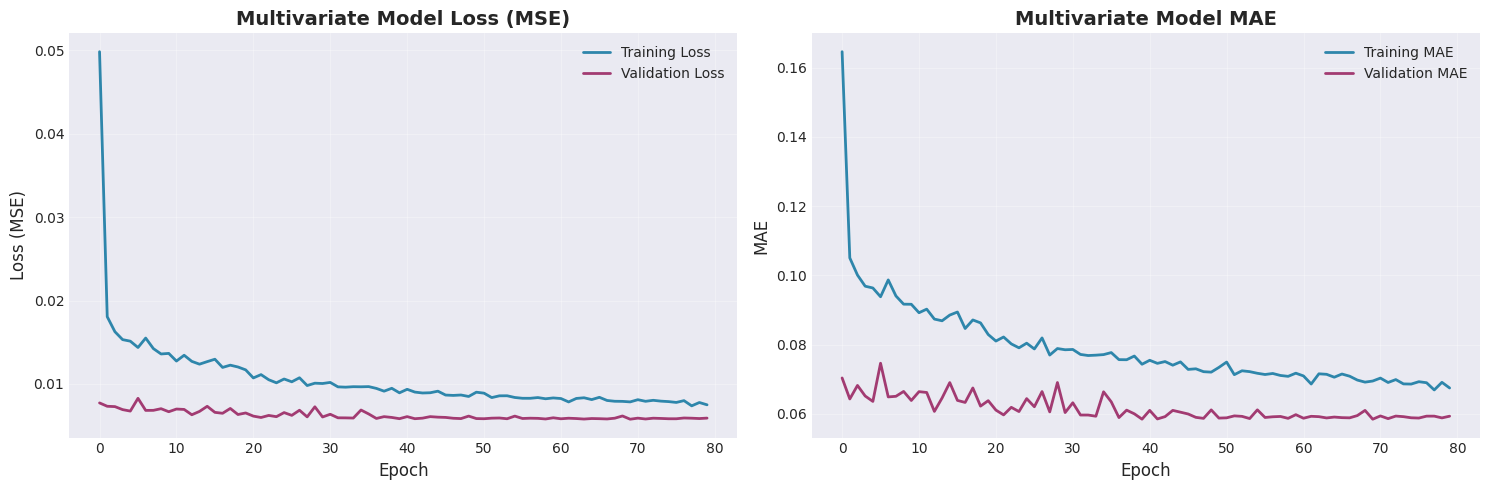

In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
axes[0].set_title('Multivariate Model Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='#2E86AB')
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='#A23B72')
axes[1].set_title('Multivariate Model MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Make Predictions

In [11]:
# Make predictions
print(f"🔮 Making predictions with multivariate model...")
train_predictions = model.predict(X_train, verbose=0)
test_predictions = model.predict(X_test, verbose=0)

# Inverse transform predictions
# We need to create dummy arrays with all features to use the scaler
def inverse_transform_target(predictions: np.ndarray, scaler: MinMaxScaler, num_features: int) -> np.ndarray:
    """
    Inverse transform predictions (only first feature: MeanTemp).
    
    Args:
        predictions: Scaled predictions
        scaler: Fitted MinMaxScaler
        num_features: Total number of features
        
    Returns:
        Inverse transformed predictions
    """
    # Create dummy array with all features (set others to 0)
    dummy = np.zeros((len(predictions), num_features))
    dummy[:, 0] = predictions.flatten()  # First column is MeanTemp
    
    # Inverse transform
    inverse = scaler.inverse_transform(dummy)
    
    # Return only the first column (MeanTemp)
    return inverse[:, 0].reshape(-1, 1)

num_features = len(available_features)
train_predictions_original = inverse_transform_target(train_predictions, scaler, num_features)
test_predictions_original = inverse_transform_target(test_predictions, scaler, num_features)
y_train_original = inverse_transform_target(y_train.reshape(-1, 1), scaler, num_features)
y_test_original = inverse_transform_target(y_test.reshape(-1, 1), scaler, num_features)

print("✅ Predictions completed and inverse transformed to original scale!")

🔮 Making predictions with multivariate model...
✅ Predictions completed and inverse transformed to original scale!


## 9. Calculate Performance Metrics

In [12]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Calculate performance metrics.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        
    Returns:
        Dictionary containing performance metrics
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2 Score': r2
    }
    
    return metrics

# Calculate metrics for training set
train_metrics = calculate_metrics(y_train_original, train_predictions_original)
print(f"\n📊 Training Set Metrics (Multivariate LSTM):")
print("="*70)
for metric, value in train_metrics.items():
    print(f"  {metric:15s}: {value:.6f}")

print("\n" + "="*70 + "\n")

# Calculate metrics for test set
test_metrics = calculate_metrics(y_test_original, test_predictions_original)
print(f"🎯 Test Set Metrics (Multivariate LSTM):")
print("="*70)
for metric, value in test_metrics.items():
    print(f"  {metric:15s}: {value:.6f}")

print("\n" + "="*70)


📊 Training Set Metrics (Multivariate LSTM):
  MSE            : 0.683307
  RMSE           : 0.826624
  MAE            : 0.632778
  R2 Score       : 0.795605


🎯 Test Set Metrics (Multivariate LSTM):
  MSE            : 0.700452
  RMSE           : 0.836930
  MAE            : 0.637648
  R2 Score       : 0.716997



## 10. Visualize Predictions

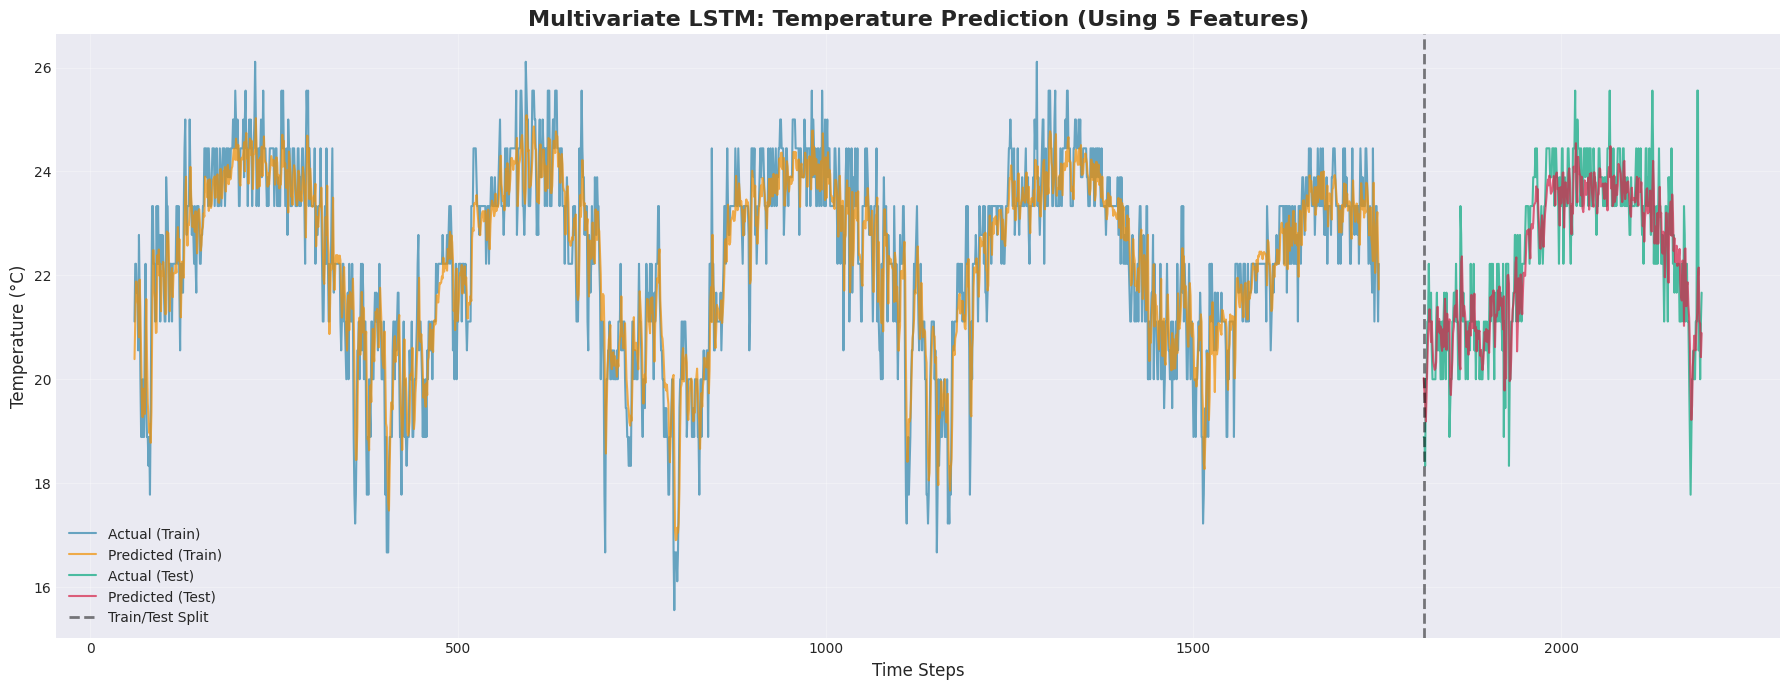

In [13]:
# Plot predictions vs actual values
plt.figure(figsize=(18, 7))

# Training data
train_plot_x = np.arange(lookback, lookback + len(train_predictions_original))
plt.plot(train_plot_x, y_train_original, label='Actual (Train)', 
         color='#2E86AB', alpha=0.7, linewidth=1.5)
plt.plot(train_plot_x, train_predictions_original, label='Predicted (Train)', 
         color='#F18F01', alpha=0.7, linewidth=1.5)

# Test data
test_plot_x = np.arange(train_size + lookback, train_size + lookback + len(test_predictions_original))
plt.plot(test_plot_x, y_test_original, label='Actual (Test)', 
         color='#06A77D', alpha=0.7, linewidth=1.5)
plt.plot(test_plot_x, test_predictions_original, label='Predicted (Test)', 
         color='#D62246', alpha=0.7, linewidth=1.5)

# Add vertical line to separate train and test
plt.axvline(x=train_size + lookback, color='black', linestyle='--', 
            linewidth=2, label='Train/Test Split', alpha=0.5)

plt.title(f'Multivariate LSTM: Temperature Prediction (Using {len(available_features)} Features)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

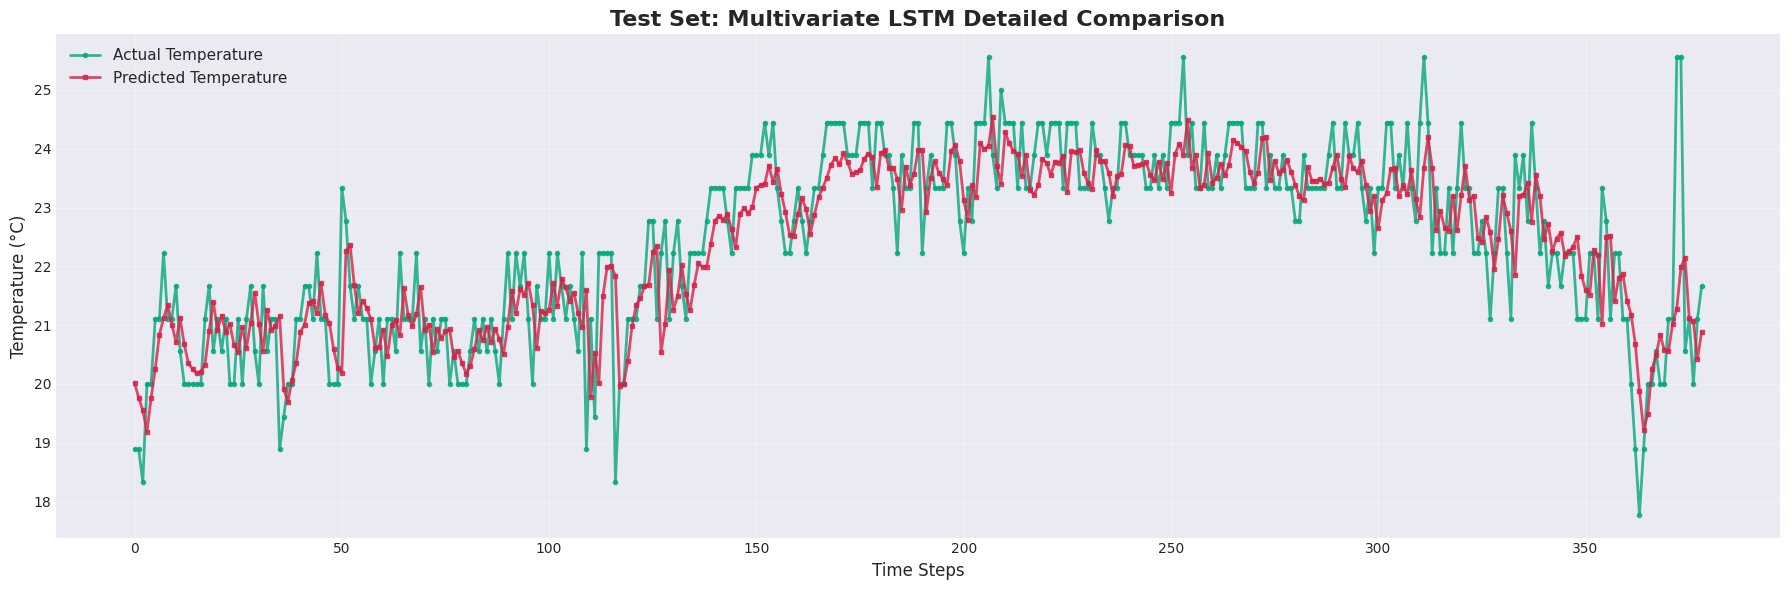

In [14]:
# Zoom in on test predictions
plt.figure(figsize=(18, 6))
plt.plot(y_test_original, label='Actual Temperature', 
         color='#06A77D', linewidth=2, marker='o', markersize=3, alpha=0.8)
plt.plot(test_predictions_original, label='Predicted Temperature', 
         color='#D62246', linewidth=2, marker='s', markersize=3, alpha=0.8)
plt.title(f'Test Set: Multivariate LSTM Detailed Comparison', 
          fontsize=16, fontweight='bold')
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

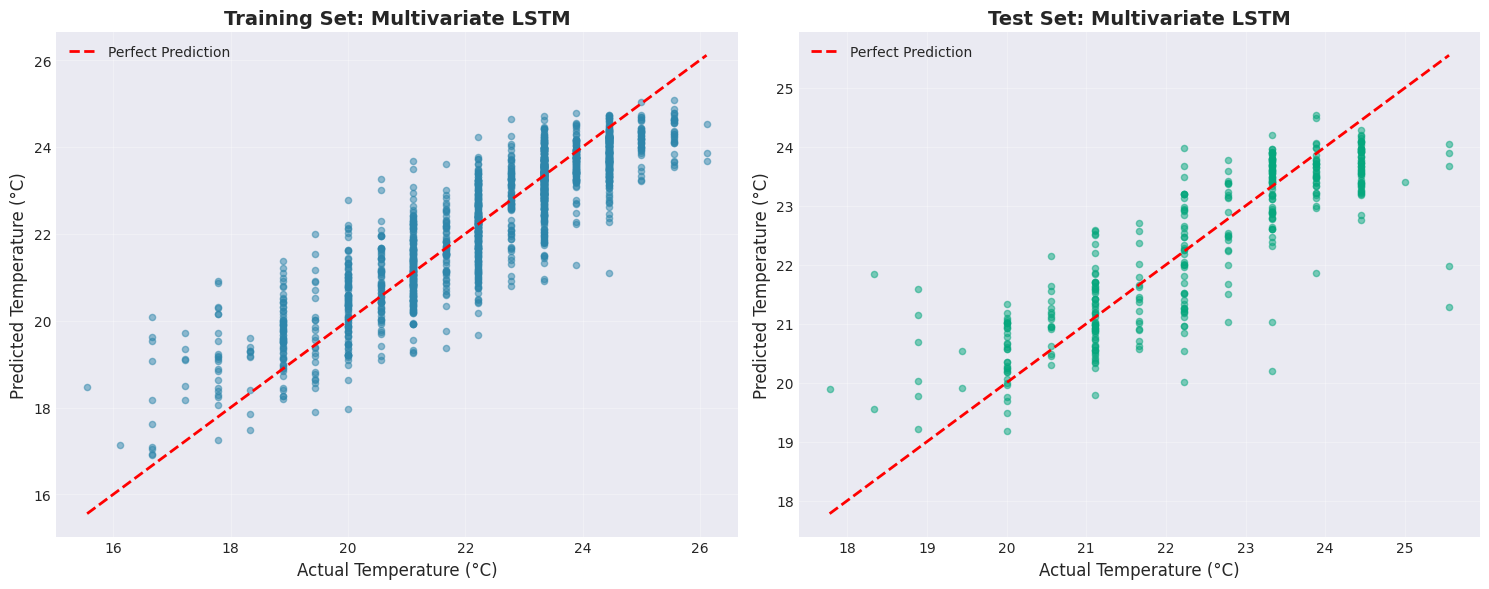

In [15]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training set
axes[0].scatter(y_train_original, train_predictions_original, alpha=0.5, s=20, color='#2E86AB')
axes[0].plot([y_train_original.min(), y_train_original.max()], 
             [y_train_original.min(), y_train_original.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title(f'Training Set: Multivariate LSTM', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Temperature (°C)', fontsize=12)
axes[0].set_ylabel('Predicted Temperature (°C)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test_original, test_predictions_original, alpha=0.5, s=20, color='#06A77D')
axes[1].plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title(f'Test Set: Multivariate LSTM', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Predicted Temperature (°C)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Residual Analysis

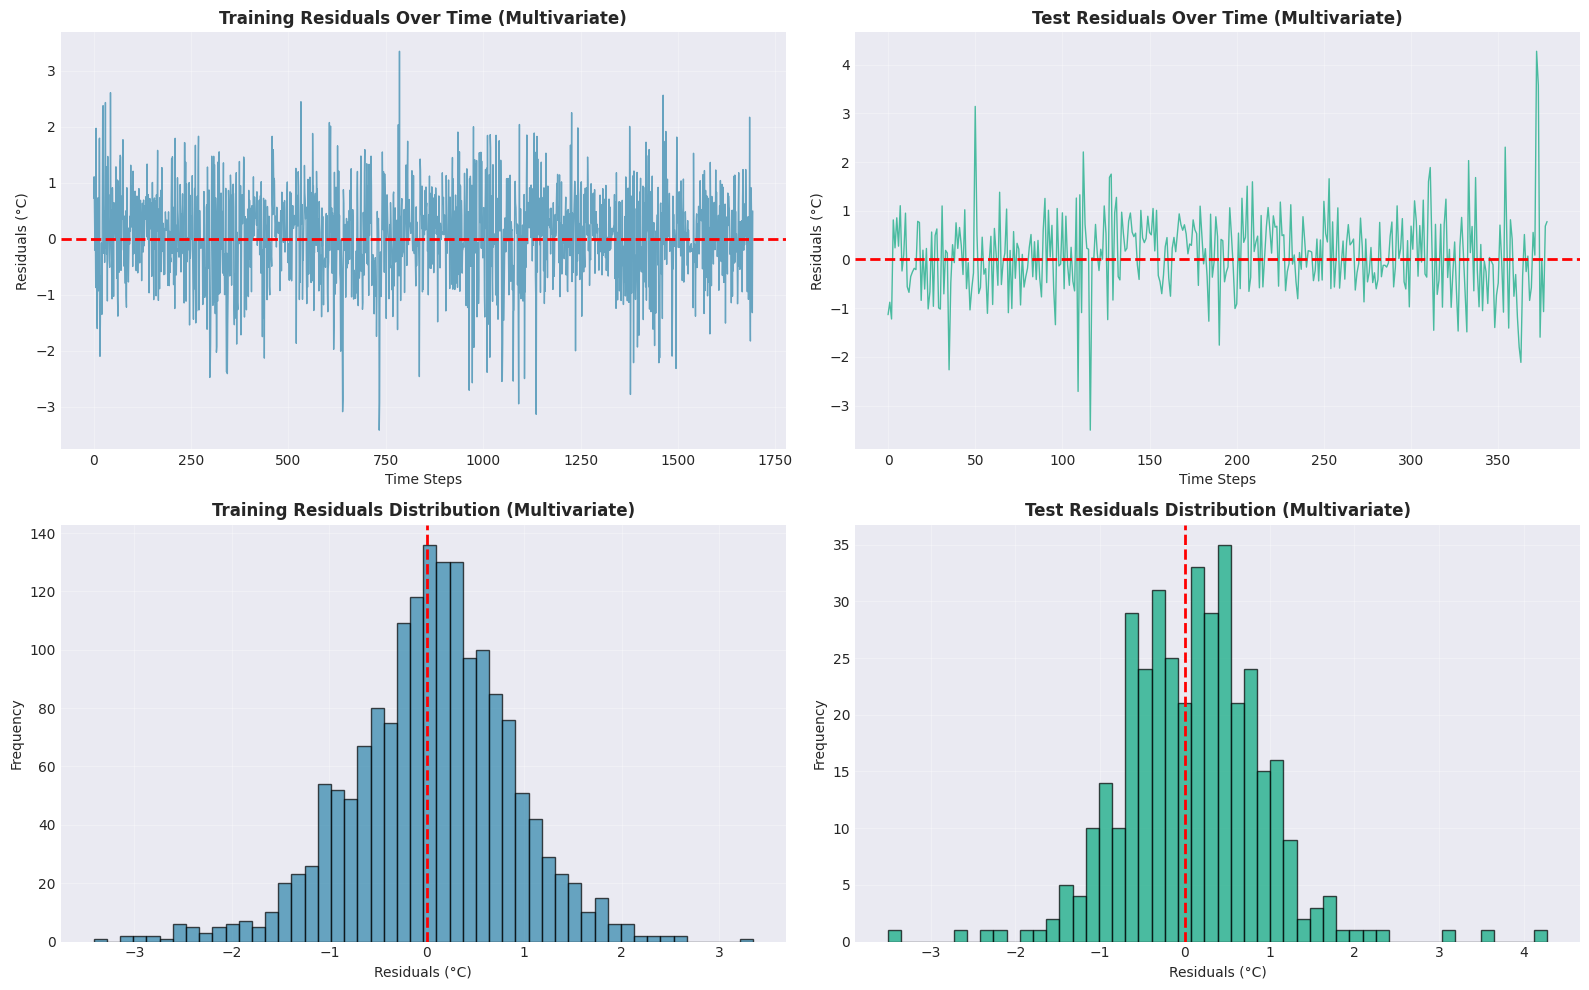


📊 Training Residuals: Mean=0.0420°C, Std=0.8256°C
📊 Test Residuals: Mean=0.0886°C, Std=0.8322°C


In [16]:
# Calculate residuals
train_residuals = y_train_original - train_predictions_original
test_residuals = y_test_original - test_predictions_original

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Training residuals over time
axes[0, 0].plot(train_residuals, color='#2E86AB', alpha=0.7, linewidth=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_title(f'Training Residuals Over Time (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time Steps', fontsize=10)
axes[0, 0].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Test residuals over time
axes[0, 1].plot(test_residuals, color='#06A77D', alpha=0.7, linewidth=1)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_title(f'Test Residuals Over Time (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time Steps', fontsize=10)
axes[0, 1].set_ylabel('Residuals (°C)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Training residuals distribution
axes[1, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='#2E86AB')
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'Training Residuals Distribution (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Test residuals distribution
axes[1, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='#06A77D')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title(f'Test Residuals Distribution (Multivariate)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Residuals (°C)', fontsize=10)
axes[1, 1].set_ylabel('Frequency', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Training Residuals: Mean={train_residuals.mean():.4f}°C, Std={train_residuals.std():.4f}°C")
print(f"📊 Test Residuals: Mean={test_residuals.mean():.4f}°C, Std={test_residuals.std():.4f}°C")

## 12. Feature Importance Analysis


📊 Feature Importance Analysis:
Analyzing how each feature correlates with prediction errors...

MeanTemp       : -0.0115 correlation with prediction error
MaxTemp        : -0.1775 correlation with prediction error
MinTemp        : -0.0416 correlation with prediction error
Precip         : +0.1633 correlation with prediction error
Snowfall       : +nan correlation with prediction error


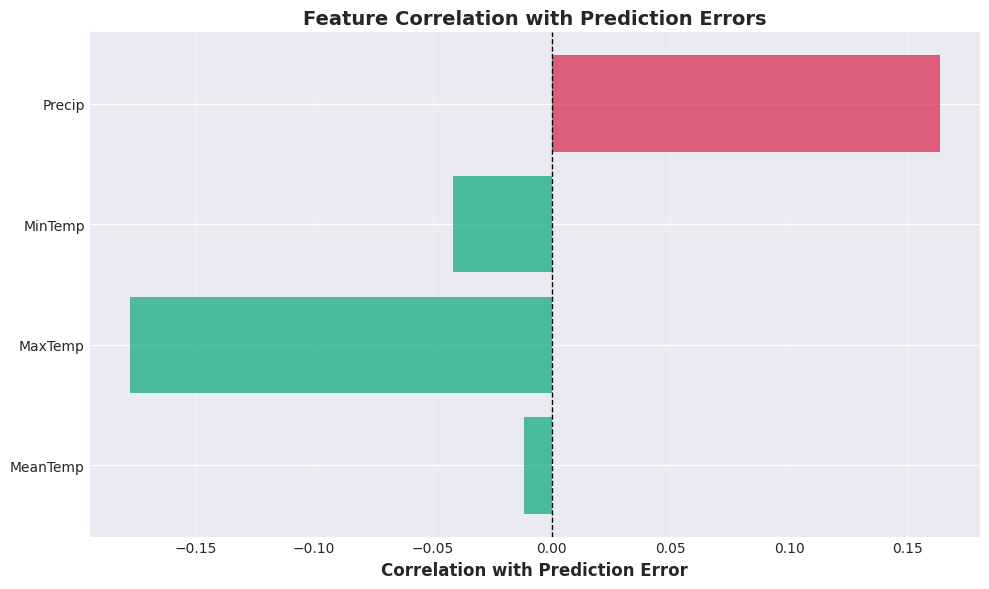


💡 Interpretation:
  • Positive correlation: Feature values increase with prediction errors
  • Negative correlation: Feature values decrease with prediction errors
  • Near zero: Feature has little relationship with errors


In [17]:
# Analyze feature importance through correlation with prediction errors
print("\n📊 Feature Importance Analysis:")
print("="*70)
print("Analyzing how each feature correlates with prediction errors...\n")

# Get test data features (inverse transformed)
test_features_scaled = feature_data_scaled[train_size+lookback:train_size+lookback+len(test_residuals)]
test_features_original = scaler.inverse_transform(test_features_scaled)

# Calculate correlation between features and absolute errors
abs_errors = np.abs(test_residuals.flatten())

feature_correlations = {}
for idx, feature in enumerate(available_features):
    corr = np.corrcoef(test_features_original[:, idx], abs_errors)[0, 1]
    feature_correlations[feature] = corr
    print(f"{feature:15s}: {corr:+.4f} correlation with prediction error")

# Visualize feature importance
plt.figure(figsize=(10, 6))
features = list(feature_correlations.keys())
correlations = list(feature_correlations.values())
colors = ['#D62246' if c > 0 else '#06A77D' for c in correlations]

plt.barh(features, correlations, color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Correlation with Prediction Error', fontsize=12, fontweight='bold')
plt.title('Feature Correlation with Prediction Errors', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("  • Positive correlation: Feature values increase with prediction errors")
print("  • Negative correlation: Feature values decrease with prediction errors")
print("  • Near zero: Feature has little relationship with errors")

## 13. Comparison with Univariate Model


📊 Comparison: Multivariate vs Univariate LSTM

Univariate LSTM (MeanTemp only):
  Test RMSE: 0.836967
  Test MAE:  0.636601
  Test R²:   0.716972

Multivariate LSTM (5 features):
  Test RMSE: 0.836930
  Test MAE:  0.637648
  Test R²:   0.716997

📈 Improvement:
  RMSE: +0.00% (better)
  MAE:  -0.16% (worse)
  R²:   +0.00% (better)


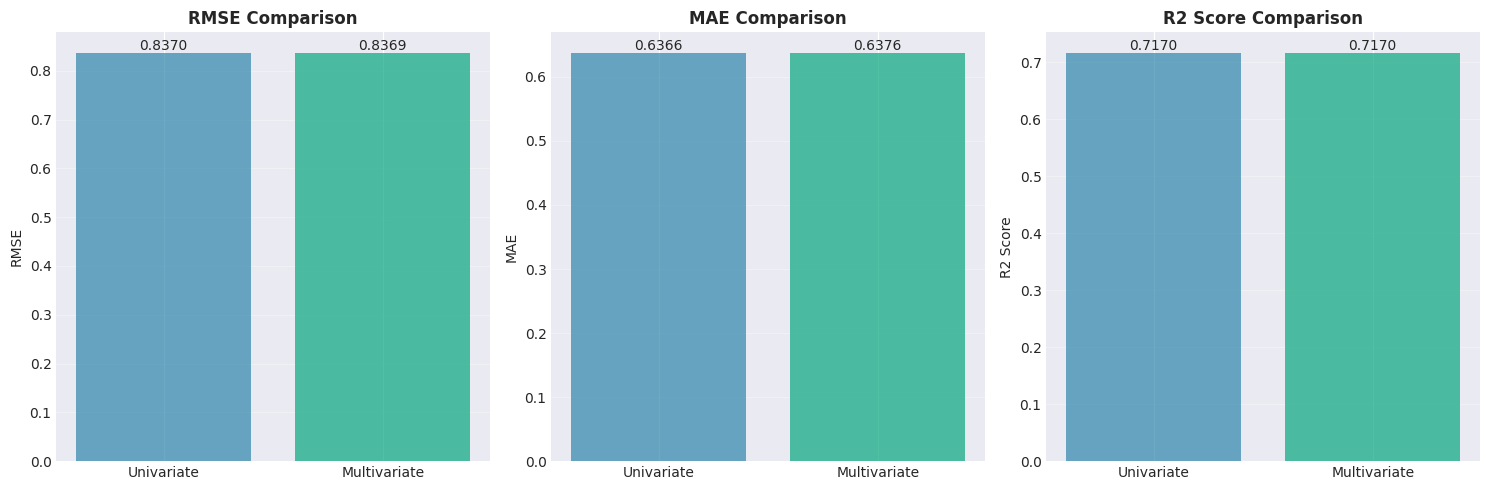

In [18]:
# Load univariate model results if available
import json
import os

print("\n📊 Comparison: Multivariate vs Univariate LSTM")
print("="*70)

# Try to load univariate model metrics
univariate_metrics_file = f'model_metrics_station_{selected_station}.json' if selected_station else 'model_metrics.json'

if os.path.exists(univariate_metrics_file):
    with open(univariate_metrics_file, 'r') as f:
        univariate_results = json.load(f)
    
    univariate_test = univariate_results['test_metrics']
    
    print("\nUnivariate LSTM (MeanTemp only):")
    print(f"  Test RMSE: {univariate_test['RMSE']:.6f}")
    print(f"  Test MAE:  {univariate_test['MAE']:.6f}")
    print(f"  Test R²:   {univariate_test['R2 Score']:.6f}")
    
    print(f"\nMultivariate LSTM ({len(available_features)} features):")
    print(f"  Test RMSE: {test_metrics['RMSE']:.6f}")
    print(f"  Test MAE:  {test_metrics['MAE']:.6f}")
    print(f"  Test R²:   {test_metrics['R2 Score']:.6f}")
    
    print("\n📈 Improvement:")
    rmse_improvement = ((univariate_test['RMSE'] - test_metrics['RMSE']) / univariate_test['RMSE']) * 100
    mae_improvement = ((univariate_test['MAE'] - test_metrics['MAE']) / univariate_test['MAE']) * 100
    r2_improvement = ((test_metrics['R2 Score'] - univariate_test['R2 Score']) / univariate_test['R2 Score']) * 100
    
    print(f"  RMSE: {rmse_improvement:+.2f}% {'(better)' if rmse_improvement > 0 else '(worse)'}")
    print(f"  MAE:  {mae_improvement:+.2f}% {'(better)' if mae_improvement > 0 else '(worse)'}")
    print(f"  R²:   {r2_improvement:+.2f}% {'(better)' if r2_improvement > 0 else '(worse)'}")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    metrics_names = ['RMSE', 'MAE', 'R2 Score']
    univariate_vals = [univariate_test['RMSE'], univariate_test['MAE'], univariate_test['R2 Score']]
    multivariate_vals = [test_metrics['RMSE'], test_metrics['MAE'], test_metrics['R2 Score']]
    
    for idx, (ax, metric_name) in enumerate(zip(axes, metrics_names)):
        x = ['Univariate', 'Multivariate']
        y = [univariate_vals[idx], multivariate_vals[idx]]
        colors = ['#2E86AB', '#06A77D']
        
        bars = ax.bar(x, y, color=colors, alpha=0.7)
        ax.set_title(f'{metric_name} Comparison', fontsize=12, fontweight='bold')
        ax.set_ylabel(metric_name, fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️  Univariate model results not found for comparison.")
    print("   Run the univariate LSTM notebook first to enable comparison.")
    print(f"\nMultivariate LSTM Results ({len(available_features)} features):")
    print(f"  Test RMSE: {test_metrics['RMSE']:.6f}")
    print(f"  Test MAE:  {test_metrics['MAE']:.6f}")
    print(f"  Test R²:   {test_metrics['R2 Score']:.6f}")

print("\n" + "="*70)

## 14. Save Model and Results

In [19]:
import json

# Save the final model
model_filename = f'multivariate_lstm_model{station_suffix}.h5'
model.save(model_filename)
print(f"✅ Model saved as '{model_filename}'")

# Save predictions to CSV
predictions_df = pd.DataFrame({
    'Actual_Test': y_test_original.flatten(),
    'Predicted_Test': test_predictions_original.flatten(),
    'Residuals': test_residuals.flatten(),
    'Absolute_Error': np.abs(test_residuals.flatten())
})

if selected_station:
    predictions_df.insert(0, 'Station_ID', selected_station)

predictions_filename = f'multivariate_predictions{station_suffix}.csv'
predictions_df.to_csv(predictions_filename, index=False)
print(f"✅ Predictions saved as '{predictions_filename}'")

# Save metrics to JSON
metrics_summary = {
    'model_type': 'Multivariate LSTM',
    'data_source': 'Summary of Weather.csv',
    'station_id': int(selected_station) if selected_station else None,
    'target_variable': available_features[0],
    'input_features': available_features,
    'num_features': len(available_features),
    'training_metrics': {k: float(v) for k, v in train_metrics.items()},
    'test_metrics': {k: float(v) for k, v in test_metrics.items()},
    'model_config': {
        'lookback': lookback,
        'lstm_units': [50, 50],
        'dropout_rate': 0.2,
        'epochs_trained': len(history.history['loss']),
        'batch_size': 32,
        'optimizer': 'adam',
        'loss_function': 'mean_squared_error'
    },
    'data_split': {
        'train_size': len(X_train),
        'test_size': len(X_test),
        'train_percentage': 80,
        'test_percentage': 20
    }
}

metrics_filename = f'multivariate_metrics{station_suffix}.json'
with open(metrics_filename, 'w') as f:
    json.dump(metrics_summary, f, indent=4)

print(f"✅ Metrics saved as '{metrics_filename}'")
print("\n🎉 All results saved successfully!")
print(f"\n📁 Generated Files:")
print(f"  • {model_filename} - Trained multivariate LSTM model")
print(f"  • best_multivariate_lstm{station_suffix}.h5 - Best model checkpoint")
print(f"  • {predictions_filename} - Test predictions and errors")
print(f"  • {metrics_filename} - Comprehensive metrics and configuration")

✅ Model saved as 'multivariate_lstm_model_station_22508.h5'
✅ Predictions saved as 'multivariate_predictions_station_22508.csv'
✅ Metrics saved as 'multivariate_metrics_station_22508.json'

🎉 All results saved successfully!

📁 Generated Files:
  • multivariate_lstm_model_station_22508.h5 - Trained multivariate LSTM model
  • best_multivariate_lstm_station_22508.h5 - Best model checkpoint
  • multivariate_predictions_station_22508.csv - Test predictions and errors
  • multivariate_metrics_station_22508.json - Comprehensive metrics and configuration


## 15. Summary Report

In [20]:
print("\n" + "="*80)
print(" "*20 + "🌡️  MULTIVARIATE LSTM TEMPERATURE PREDICTION")
print("="*80)

print("\n📊 MODEL CONFIGURATION:")
print("-"*80)
print(f"  • Model Type: Multivariate LSTM")
print(f"  • Data Source: Summary of Weather.csv")
if selected_station:
    print(f"  • Station ID: {selected_station}")
print(f"  • Target Variable: {available_features[0]}")
print(f"  • Input Features: {', '.join(available_features)}")
print(f"  • Number of Features: {len(available_features)}")
print(f"  • Lookback Period: {lookback} time steps (days)")
print(f"  • Training Samples: {len(X_train)}")
print(f"  • Test Samples: {len(X_test)}")
print(f"  • Total Epochs: {len(history.history['loss'])}")
print(f"  • LSTM Architecture: 2 layers with 50 units each")
print(f"  • Dropout Rate: 0.2")

print("\n📈 TRAINING SET PERFORMANCE:")
print("-"*80)
for metric, value in train_metrics.items():
    print(f"  • {metric:15s}: {value:.6f}")

print("\n🎯 TEST SET PERFORMANCE:")
print("-"*80)
for metric, value in test_metrics.items():
    print(f"  • {metric:15s}: {value:.6f}")

print("\n💡 MODEL INSIGHTS:")
print("-"*80)

# Calculate percentage errors
train_mape = np.mean(np.abs((y_train_original - train_predictions_original) / y_train_original)) * 100
test_mape = np.mean(np.abs((y_test_original - test_predictions_original) / y_test_original)) * 100

print(f"  • Training MAPE: {train_mape:.2f}%")
print(f"  • Test MAPE: {test_mape:.2f}%")
print(f"  • Model explains {test_metrics['R2 Score']*100:.2f}% of variance in test data")
print(f"  • Average prediction error on test set: {test_metrics['MAE']:.4f}°C")
print(f"  • Using {len(available_features)} features vs 1 feature in univariate model")

print("\n🏆 PERFORMANCE EVALUATION:")
print("-"*80)
if test_metrics['R2 Score'] > 0.9:
    print(f"  ✅ Excellent multivariate model performance!")
    print("     The model captures temperature patterns very well using multiple features.")
elif test_metrics['R2 Score'] > 0.7:
    print(f"  ✅ Good multivariate model performance!")
    print("     The model shows strong predictive capability with multiple features.")
elif test_metrics['R2 Score'] > 0.5:
    print(f"  ⚠️  Moderate multivariate model performance.")
    print("     Consider feature engineering or trying different feature combinations.")
else:
    print(f"  ⚠️  Poor multivariate model performance.")
    print("     The additional features may not be providing useful information.")

print("\n🔑 KEY ADVANTAGES OF MULTIVARIATE MODEL:")
print("-"*80)
print("  • Captures relationships between multiple weather variables")
print("  • Leverages correlation between temperature, precipitation, snowfall, etc.")
print("  • More robust to noise in individual features")
print("  • Better generalization through richer context")

print("\n" + "="*80 + "\n")


                    🌡️  MULTIVARIATE LSTM TEMPERATURE PREDICTION

📊 MODEL CONFIGURATION:
--------------------------------------------------------------------------------
  • Model Type: Multivariate LSTM
  • Data Source: Summary of Weather.csv
  • Station ID: 22508
  • Target Variable: MeanTemp
  • Input Features: MeanTemp, MaxTemp, MinTemp, Precip, Snowfall
  • Number of Features: 5
  • Lookback Period: 60 time steps (days)
  • Training Samples: 1693
  • Test Samples: 379
  • Total Epochs: 80
  • LSTM Architecture: 2 layers with 50 units each
  • Dropout Rate: 0.2

📈 TRAINING SET PERFORMANCE:
--------------------------------------------------------------------------------
  • MSE            : 0.683307
  • RMSE           : 0.826624
  • MAE            : 0.632778
  • R2 Score       : 0.795605

🎯 TEST SET PERFORMANCE:
--------------------------------------------------------------------------------
  • MSE            : 0.700452
  • RMSE           : 0.836930
  • MAE            : 0.637648
 

## Conclusion

### ✅ What We Accomplished:

1. **Multivariate LSTM Implementation**
   - Built LSTM model that uses multiple weather features simultaneously
   - Input shape: (lookback, num_features) instead of (lookback, 1)
   - Learns relationships between temperature, precipitation, snowfall, etc.

2. **Feature Engineering**
   - Selected relevant weather features from dataset
   - Normalized all features independently
   - Created multivariate sequences for LSTM input

3. **Model Evaluation**
   - Comprehensive metrics: MSE, RMSE, MAE, R² Score
   - Residual analysis and error distributions
   - Feature importance analysis
   - Comparison with univariate model (if available)

4. **Visualization**
   - Predictions vs actual values
   - Training history and convergence
   - Residual patterns
   - Feature correlations

### 🎯 Key Differences from Univariate Model:

| Aspect | Univariate LSTM | Multivariate LSTM |
|--------|----------------|-------------------|
| **Input Features** | 1 (MeanTemp only) | Multiple (MeanTemp, MaxTemp, MinTemp, Precip, Snowfall) |
| **Input Shape** | (samples, 60, 1) | (samples, 60, num_features) |
| **Learning** | Temporal patterns in temperature | Temporal patterns + inter-feature relationships |
| **Complexity** | Lower | Higher |
| **Data Requirements** | Less data needed | More data recommended |
| **Interpretability** | Simpler | More complex |

### 🚀 When to Use Multivariate LSTM:

**Use Multivariate when:**
- ✅ Multiple relevant features are available
- ✅ Features show correlation with target variable
- ✅ Sufficient training data (thousands of samples)
- ✅ Need to capture complex inter-variable relationships

**Use Univariate when:**
- ✅ Limited features available
- ✅ Smaller dataset
- ✅ Simpler interpretation needed
- ✅ Single feature already provides good results

### 📚 Resources:
- [Multivariate Time Series Forecasting with LSTMs](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Time Series Forecasting with Deep Learning](https://www.tensorflow.org/tutorials/structured_data/time_series)